In [56]:
import numpy as np
import torch
from transformers import *
from sklearn.cluster import KMeans
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [87]:
train_embeddings = {}
test_embeddings = {}
sents = np.load('openaiGPT/sentences.npy')
vectors = np.load('openaiGPT/vectors.npy')
domain = np.load('openaiGPT/domain.npy')
sentiment = np.load('openaiGPT/sentiment.npy')

split = int(0.8 * len(sents))
train_embeddings['sents'] = sents[:split]
train_embeddings['vectors'] = vectors[:split]
train_embeddings['domain'] = domain[:split]
train_embeddings['sentiment'] = sentiment[:split]
test_embeddings['sents'] = sents[split:]
test_embeddings['vectors'] = vectors[split:]
test_embeddings['domain'] = domain[split:]
test_embeddings['sentiment'] = sentiment[split:]

In [95]:
DOMAINS = ['Automotive', 'Books', 'Music', 'Software', 'Baby']
N_CLUSTERS = 10

def kmeans(train_data, num_clusters=5):
    model = KMeans(n_clusters=num_clusters,
                   max_iter=250,
                   random_state=1,
                   verbose=1)
    
    model.fit(train_data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=8):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * len(DOMAINS)
        for i, pred in enumerate(predictions):
            if pred == k:
                count[DOMAINS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (DOMAINS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [96]:
start = time.time()
model = kmeans(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization complete
Iteration 0, inertia 2123910.5
Iteration 1, inertia 1293753.5
Iteration 2, inertia 1267760.0
Iteration 3, inertia 1260298.75
Iteration 4, inertia 1256716.125
Iteration 5, inertia 1254859.625
Iteration 6, inertia 1254001.375
Iteration 7, inertia 1253540.875
Iteration 8, inertia 1253231.875
Iteration 9, inertia 1252921.625
Iteration 10, inertia 1252628.5
Iteration 11, inertia 1252231.125
Iteration 12, inertia 1251721.375
Iteration 13, inertia 1251085.875
Iteration 14, inertia 1250390.5
Iteration 15, inertia 1249834.0
Iteration 16, inertia 1249459.375
Iteration 17, inertia 1249187.625
Iteration 18, inertia 1249005.625
Iteration 19, inertia 1248856.875
Iteration 20, inertia 1248749.125
Iteration 21, inertia 1248681.75
Iteration 22, inertia 1248637.5
Iteration 23, inertia 1248602.75
Iteration 24, inertia 1248572.125
Iteration 25, inertia 1248543.25
Iteration 26, inertia 1248520.125
Iteration 27, inertia 1248490.0
Iteration 28, inertia 1248437.75
Iteration 29, inertia

Initialization complete
Iteration 0, inertia 2195867.75
Iteration 1, inertia 1312861.625
Iteration 2, inertia 1281025.0
Iteration 3, inertia 1268613.0
Iteration 4, inertia 1262288.25
Iteration 5, inertia 1259546.5
Iteration 6, inertia 1257951.875
Iteration 7, inertia 1256744.875
Iteration 8, inertia 1255681.0
Iteration 9, inertia 1254774.625
Iteration 10, inertia 1254025.5
Iteration 11, inertia 1253460.5
Iteration 12, inertia 1253031.25
Iteration 13, inertia 1252724.125
Iteration 14, inertia 1252524.5
Iteration 15, inertia 1252375.0
Iteration 16, inertia 1252268.125
Iteration 17, inertia 1252164.625
Iteration 18, inertia 1252094.5
Iteration 19, inertia 1252040.0
Iteration 20, inertia 1252001.375
Iteration 21, inertia 1251980.875
Iteration 22, inertia 1251964.375
Iteration 23, inertia 1251949.875
Iteration 24, inertia 1251936.625
Iteration 25, inertia 1251890.75
Iteration 26, inertia 1251857.375
Iteration 27, inertia 1251834.125
Iteration 28, inertia 1251812.125
Iteration 29, inertia 12

Iteration 21, inertia 1250511.25
Iteration 22, inertia 1250175.0
Iteration 23, inertia 1249731.375
Iteration 24, inertia 1249199.75
Iteration 25, inertia 1248671.0
Iteration 26, inertia 1248170.125
Iteration 27, inertia 1247805.875
Iteration 28, inertia 1247568.875
Iteration 29, inertia 1247412.625
Iteration 30, inertia 1247280.75
Iteration 31, inertia 1247207.5
Iteration 32, inertia 1247151.75
Iteration 33, inertia 1247116.0
Iteration 34, inertia 1247088.5
Iteration 35, inertia 1247064.75
Iteration 36, inertia 1247048.25
Iteration 37, inertia 1247038.375
Iteration 38, inertia 1247032.0
Iteration 39, inertia 1247026.625
Iteration 40, inertia 1247020.0
Iteration 41, inertia 1247016.25
Iteration 42, inertia 1247012.625
Iteration 43, inertia 1247009.0
Iteration 44, inertia 1247007.375
Iteration 45, inertia 1247005.125
Iteration 46, inertia 1247004.125
Iteration 47, inertia 1247003.125
Iteration 48, inertia 1247002.125
Iteration 49, inertia 1247001.625
Iteration 50, inertia 1247000.875
Ite

In [97]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['domain'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['domain'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_kmeans_k5_distilBERT.npy', test_pred)

Train accuracy is 0.7607
Test accuracy is 0.7481


In [98]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: Books | Purity: 0.4095238095238095
Cluster-2 | label: Automotive | Purity: 0.8832535885167464
Cluster-3 | label: Music | Purity: 0.3106317411402157
Cluster-4 | label: Baby | Purity: 0.9896823241922346
Cluster-5 | label: Automotive | Purity: 0.3569327731092437
Cluster-6 | label: Music | Purity: 0.9760323886639676
Cluster-7 | label: Software | Purity: 0.8730940279542567
Cluster-8 | label: Baby | Purity: 0.5175751400916964
Cluster-9 | label: Books | Purity: 0.9106172839506173
Cluster-10 | label: Books | Purity: 0.8645251396648045


In [99]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...


/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 3.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.504861
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.209480
[t-SNE] KL divergence after 1000 iterations: 2.703959


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

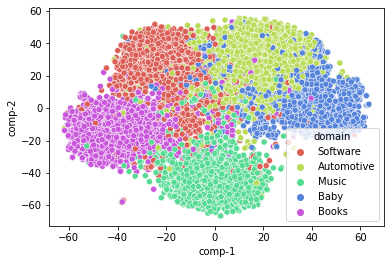

In [100]:
df = pd.DataFrame()
df["domain"] = test_embeddings['domain']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="domain", palette=sns.color_palette("hls", 5))

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

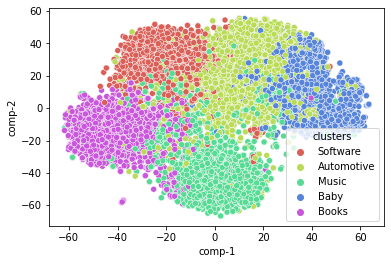

In [101]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))